## Load Data and Preprocessing

In [1]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from random import sample
import sklearn.model_selection as skl
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

Using TensorFlow backend.


In [2]:
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
64855,00016011_007.png,Consolidation|Effusion|Pneumonia,7,16011,27,F,AP,2048,2500,0.168,0.168,NaN,/data/images_007/images/00016011_007.png
12822,00003366_003.png,No Finding,3,3366,20,M,AP,2500,2048,0.171,0.171,NaN,/data/images_002/images/00003366_003.png
2565,00000661_001.png,Cardiomegaly|Infiltration,1,661,52,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000661_001.png


In [3]:
## Here we create some extra columns in the table with binary indicators of certain diseases rather than working directly with the 'Finding Labels' column
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
39716,00010377_000.png,No Finding,0,10377,66,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
75415,00018507_007.png,Effusion|Infiltration,7,18507,69,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
47831,00012127_001.png,No Finding,1,12127,35,M,PA,2894,2881,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
list(all_xray_df.columns)

['Image Index',
 'Finding Labels',
 'Follow-up #',
 'Patient ID',
 'Patient Age',
 'Patient Gender',
 'View Position',
 'OriginalImage[Width',
 'Height]',
 'OriginalImagePixelSpacing[x',
 'y]',
 'Unnamed: 11',
 'path',
 'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [5]:
## Here we create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df.drop('Unnamed: 11', axis=1, inplace=True)
all_xray_df.rename(columns={'Pneumonia':'pneumonia_class'}, inplace=True)
all_xray_df['pneumonia_class']=all_xray_df['pneumonia_class'].replace({1:'pneumonia',0:'not_pneumonia'})

In [6]:
all_xray_df['pneumonia_class'].value_counts()

not_pneumonia    110689
pneumonia          1431
Name: pneumonia_class, dtype: int64

## Train Test Split

In [7]:
def create_splits(df):
    train_df, valid_df = skl.train_test_split(df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['pneumonia_class'])
    p_inds = train_df[train_df['pneumonia_class']=='pneumonia'].index.tolist()
    np_inds = train_df[train_df['pneumonia_class']=='not_pneumonia'].index.tolist()
    np_sample = sample(np_inds,len(p_inds))
    train_df = train_df.loc[p_inds + np_sample]
    p_inds = valid_df[valid_df['pneumonia_class']=='pneumonia'].index.tolist()
    np_inds = valid_df[valid_df['pneumonia_class']=='not_pneumonia'].index.tolist()
    # The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
    np_sample = sample(np_inds,4*len(p_inds))
    valid_df = valid_df.loc[p_inds + np_sample]
    return train_df, valid_df

In [8]:
train_df, val_df=create_splits(all_xray_df)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

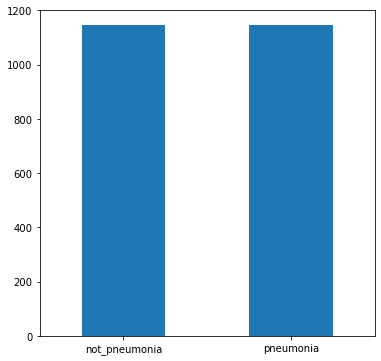

In [9]:
plt.figure(figsize=(6,6))
train_df['pneumonia_class'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)

In [10]:
train_df.shape

(2290, 27)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

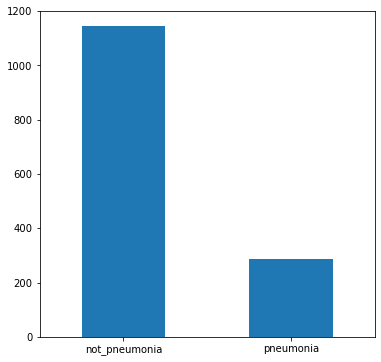

In [11]:
plt.figure(figsize=(6,6))
val_df['pneumonia_class'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)

In [12]:
val_df.shape

(1430, 27)

# model-building & training

In [13]:
def my_image_augmentation():
    my_train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

    my_val_idg = ImageDataGenerator(rescale=1./255.0)    
    return my_train_idg, my_val_idg

def make_train_gen(my_train_idg,train_df):
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col ='path',
                                         y_col ='pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 32
                                         )

    return train_gen

def make_val_gen(my_val_idg,valid_df):
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_df, 
                                             directory=None, 
                                             x_col ='path',
                                             y_col ='pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = 16) 
    
    return val_gen

In [14]:
IMG_SIZE = (224, 224)
my_train_idg,my_val_idg=my_image_augmentation()
train_gen=make_train_gen(my_train_idg,train_df)
val_gen=make_val_gen(my_val_idg,val_df)
valX, valY = val_gen.next()

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


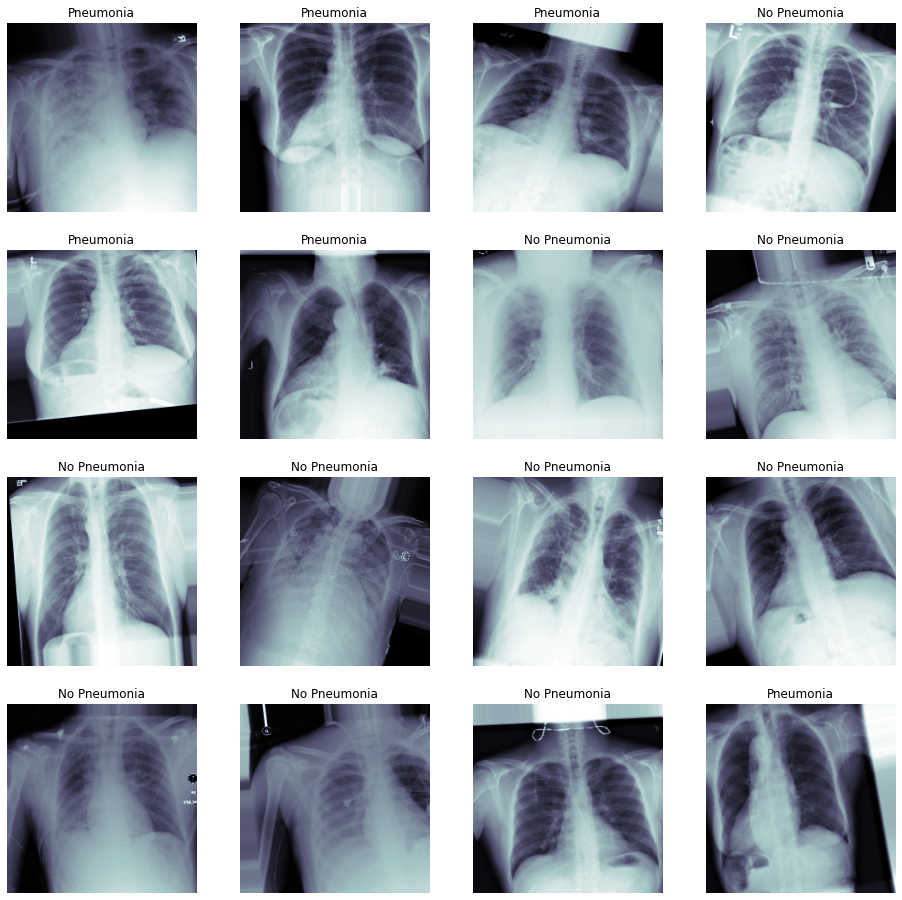

In [15]:
## look at some examples of our augmented training data. 
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build the model: 

In [16]:
def load_pretrained_model():
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    return vgg_model

In [17]:
vgg_model=load_pretrained_model()
vgg_model.summary()

553467904/553467096 [==============================] - 8s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

In [18]:
def build_my_model(vgg_model):    
    my_model = Sequential()
    # Add the convolutional part of the VGG16 model from above.
    my_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())
    my_model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']   
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return my_model

In [19]:
my_model=build_my_model(vgg_model)

In [20]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 2,384,897
Non-trainable params: 12,354,880
_________________________________________________________________


In [21]:
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Model Training

In [22]:
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs =5, 
                          callbacks = callbacks_list)

Epoch 1/5
72/72 [==============================] - 65s 905ms/step - loss: 0.7025 - binary_accuracy: 0.5384 - val_loss: 0.4945 - val_binary_accuracy: 0.6875

Epoch 00001: val_loss improved from inf to 0.49454, saving model to xray_class_my_model.best.hdf5
Epoch 2/5
72/72 [==============================] - 56s 777ms/step - loss: 0.6773 - binary_accuracy: 0.5799 - val_loss: 0.5860 - val_binary_accuracy: 0.6250

Epoch 00002: val_loss did not improve from 0.49454
Epoch 3/5
72/72 [==============================] - 58s 801ms/step - loss: 0.6699 - binary_accuracy: 0.5891 - val_loss: 0.5888 - val_binary_accuracy: 0.6875

Epoch 00003: val_loss did not improve from 0.49454
Epoch 4/5
72/72 [==============================] - 58s 800ms/step - loss: 0.6530 - binary_accuracy: 0.6118 - val_loss: 0.5912 - val_binary_accuracy: 0.6875

Epoch 00004: val_loss did not improve from 0.49454
Epoch 5/5
72/72 [==============================] - 58s 805ms/step - loss: 0.6544 - binary_accuracy: 0.6004 - val_loss: 0.

##### Plotting some performance statistics:

In [23]:
## After training, make some predictions to assess the model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect. Therefore, we did not focus on the tunning for better performance.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

16/16 [==============================] - 0s 13ms/step


In [24]:
#plotting auc curve
def plot_auc(t_y, p_y):
    fig, ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
#plotting precision recall curve 
def plot_precision_recall(t_y, p_y):
    fig, ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    ax.plot(recall, precision, label = '2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision_score(t_y, p_y)))
    ax.legend()
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
#plotting the history of your model training:
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

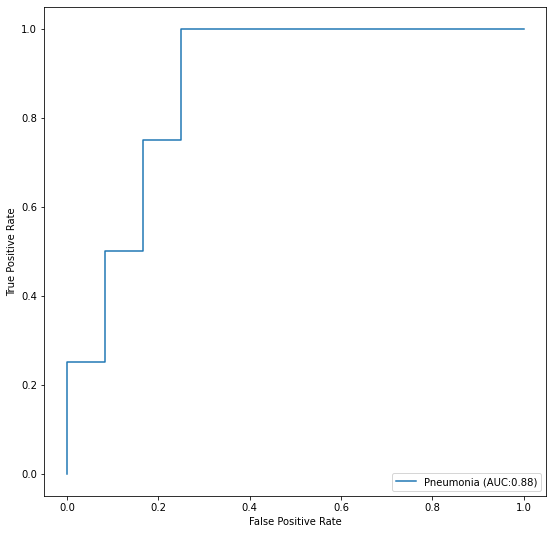

In [25]:
plot_auc(valY, pred_Y)

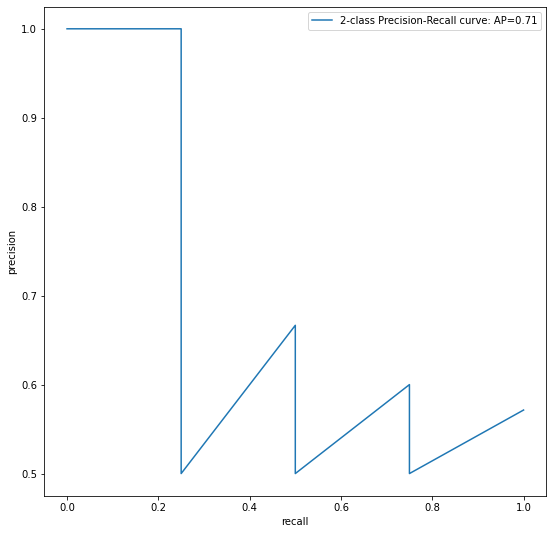

In [26]:
plot_precision_recall(valY, pred_Y)

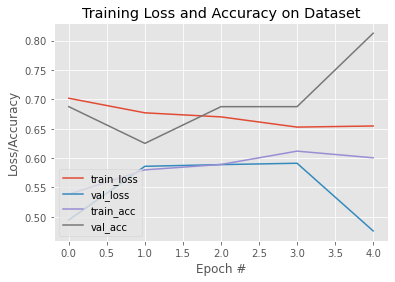

In [27]:
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

Text(0.5, 1.0, 'Precision and Recall over Thresholds')

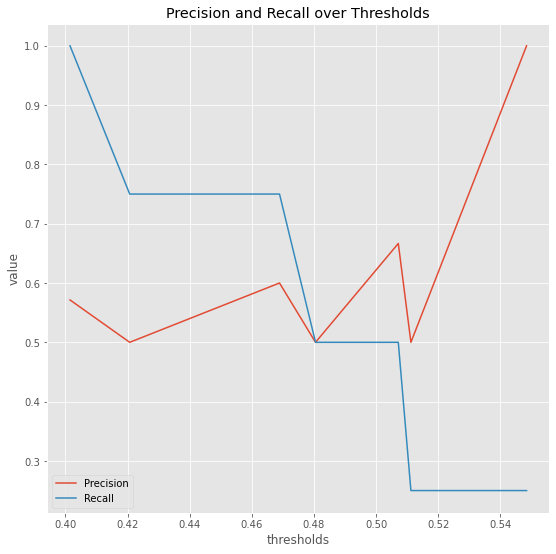

In [28]:
## Find the threshold that optimize the model's performance,
## and use that threshold to make binary classification. 
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
fig, ax = plt.subplots(1,1, figsize = (9, 9))
ax.plot(thresholds, precision[:-1], label='Precision')
ax.plot(thresholds, recall[:-1], label='Recall')
ax.legend()
ax.set_xlabel('thresholds')
ax.set_ylabel('value')
plt.title('Precision and Recall over Thresholds')

In [29]:
# Look at the threshold where recall is 0.66
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(2*(precision[idx]*recall[idx])/(precision[idx]+recall[idx])))

Precision is: 0.5
Recall is: 0.75
Threshold is: 0.42066556
F1 Score is: 0.6


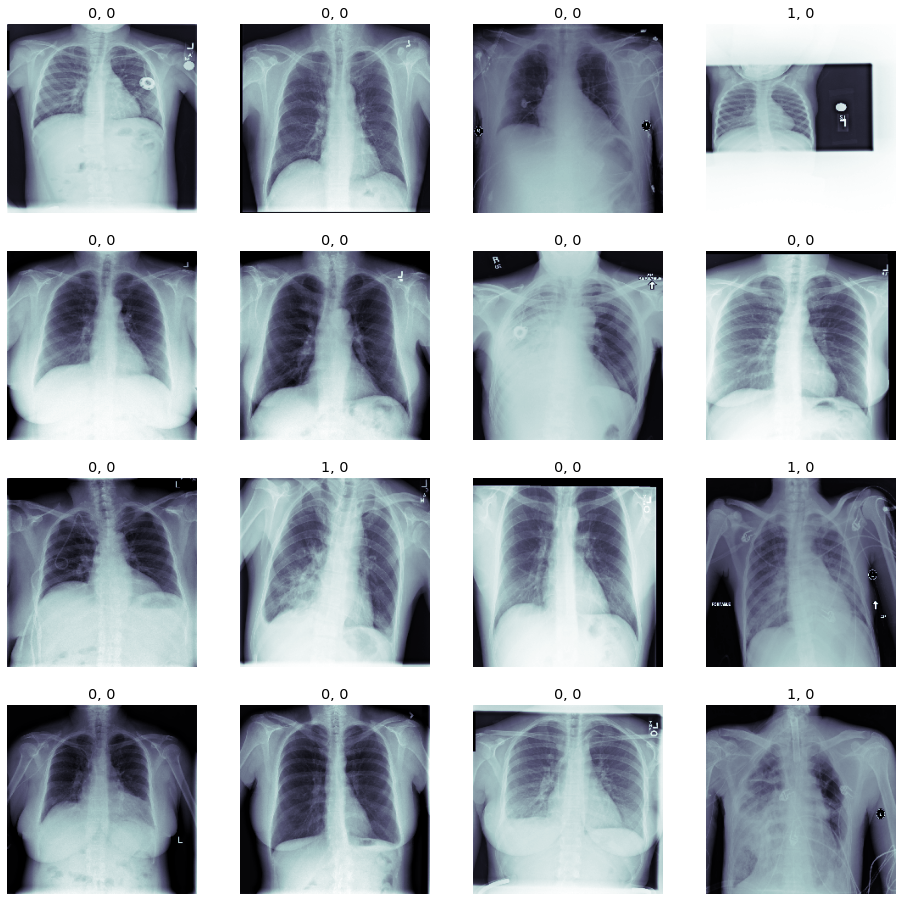

In [30]:
## Look at some examples of true vs. predicted with our best model: 
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:16], valY[0:16], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.66:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.66: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [31]:
## Just save model architecture to a .json:
model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)